In [28]:
%pip install networkx
%pip install musescore
%pip install music21

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
from music21 import converter, corpus, note, stream
from music21 import *

In [8]:
from music21 import environment
# Set the path to MuseScore
env = environment.Environment()
env['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
env['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'

In [9]:
midi = "bach_cello_suites\\Suite No. 1 in G major\\cs1-1pre.mid"
midi

'bach_cello_suites\\Suite No. 1 in G major\\cs1-1pre.mid'

## I-R Symbol Assignment

In [10]:
def get_all_notes_and_chords(score):
    notes_and_rests = []
    for part in score.parts:
        for element in part.flatten():
            if isinstance(element, note.Note):
                notes_and_rests.append(element)
            elif isinstance(element, chord.Chord):
                # Append the root note of the chord only
                root = element.root()
                notes_and_rests.append(note.Note(root.nameWithOctave))
            elif isinstance(element, note.Rest):
                # Append rests
                notes_and_rests.append(element)
    return notes_and_rests

def get_notes_with_details(score):
    note_details = []
    for part in score.parts:
        for element in part.flatten().notesAndRests:  # This now includes both notes, chords, and rests
            if isinstance(element, note.Note):
                note_details.append((element, element.offset, element.measureNumber))
            elif isinstance(element, chord.Chord):
                # Loop through each note in the chord, appending with details
                for n in element.notes:
                    note_details.append((n, element.offset, element.measureNumber))
            elif isinstance(element, note.Rest):
                # Include details for rests
                note_details.append((element, element.offset, element.measureNumber))
    return note_details

In [11]:
def calculate_ir_symbol(interval1, interval2, threshold=5):
    direction = interval1 * interval2
    abs_difference = abs(interval2-interval1)
    # Process
    if direction > 0 and (abs(interval2-interval1))<threshold:
        return 'P'  
    # IR2: D (Duplication)
    elif interval1 == interval2 == 0:
        return 'D' 
    # IR3: IP (Intervallic Process)
    elif ((interval1 * interval2)<0) and (-threshold <= (abs(interval2) - abs(interval1)) <= threshold) and (abs(interval2) != abs(interval1)):
        return 'IP' 
    # IR4: ID (Intervallic Duplication)
    elif ((interval1 * interval2) < 0) and (abs(interval2) == abs(interval1)):
        return 'ID'   
    # IR5: VP (Vector Process)
    elif (interval1 * interval2 > 0) and (abs(interval2-interval1) >= threshold) and (abs(interval1) <= threshold):
        return 'VP'
    # IR6: R (Reveral)
    elif (interval1 * interval2 < 0) and (abs(abs(interval2)-abs(interval1)) >= threshold) and (abs(interval1) >= threshold):
        return 'R'
    # IR7: IR (Intervallic Reveral)
    elif (interval1 * interval2 > 0) and (abs(abs(interval2)-abs(interval1)) >= threshold) and (abs(interval1) >= threshold):
        return 'IR' 
    # IR8: VR (Vector Reveral)
    elif (interval1 * interval2 < 0) and (abs(interval2 - interval1) >= threshold) and (abs(interval1) <= threshold):
        return 'VR'
    elif interval2 == 0 and not (interval1 < -5 or interval1 > 5):
        return 'IP'
    elif interval2 == 0 and (interval1 < -5 or interval1 > 5):
        return 'R'
    elif interval1 == 0 and not (interval2 < -5 or interval2 > 5):
        return 'P'
    elif interval1 == 0 and (interval2 < -5 or interval2 > 5):
        return 'VR'

In [12]:
# def calculate_ir_symbol(interval1, interval2):
#     same_direction = (interval1 * interval2 > 0)
#     opposite_direction = (interval1 * interval2 < 0)
#     interval_difference = abs(interval2 - interval1)
#     abs_interval1 = abs(interval1)
#     abs_interval2 = abs(interval2)
#     abs_diff = abs(abs_interval2 - abs_interval1)

#     # Process (P): Same direction, small interval change
#     if same_direction and interval_difference < 6:
#         return 'P'
#     # Duplication (D): Same interval, either direction
#     elif interval1 == interval2:
#         return 'D'
#     # Intervallic Process (IP): Opposite direction, small interval change
#     elif opposite_direction and -6 < interval_difference < 6:
#         return 'IP'
#     # Intervallic Duplication (ID): Opposite direction, same absolute interval
#     elif opposite_direction and abs_interval1 == abs_interval2:
#         return 'ID'
#     # Vector Process (VP): Same direction, large interval change, small starting interval
#     elif same_direction and interval_difference > 6 and abs_interval1 < 6:
#         return 'VP'
#     # Reversal (R): Opposite direction, large absolute difference, large starting interval
#     elif opposite_direction and abs_diff > 6 and abs_interval1 > 6:
#         return 'R'
#     # Intervallic Reversal (IR): Same direction, large absolute difference, large starting interval
#     elif same_direction and abs_diff > 6 and abs_interval1 > 6:
#         return 'IR'
#     # Vector Reversal (VR): Opposite direction, large interval change, small starting interval
#     elif opposite_direction and interval_difference > 6 and abs_interval1 < 6:
#         return 'VR'
#     # No matching symbol
#     return None


In [13]:
def assign_ir_symbols(elements):
    symbols = []
    current_group = []

    def evaluate_current_group():
        if len(current_group) == 3:
            interval1 = current_group[1].pitch.ps - current_group[0].pitch.ps
            interval2 = current_group[2].pitch.ps - current_group[1].pitch.ps
            symbol = calculate_ir_symbol(interval1, interval2)
            symbols.append(symbol)
        elif len(current_group) == 2:
            symbols.append('d')  # Dyad
        elif len(current_group) == 1:
            symbols.append('M')  # Monad
        else:
            symbols.append('Error: Invalid note object')
        current_group.clear()

    for element in elements:
        if isinstance(element, note.Note):
            current_group.append(element)
            if len(current_group) == 3:
                evaluate_current_group()
        else:
            if current_group:
                evaluate_current_group()

    # Handle any remaining notes
    if current_group:
        evaluate_current_group()

    return symbols

In [14]:
elements = [
    note.Note('C4'), note.Note('E4'), note.Rest(),
    note.Note('G4'), note.Note('D4'), note.Note('F4'),
    note.Rest(), note.Note('A4'), note.Note('C5'),
    note.Note('E5')
]

symbols = assign_ir_symbols(elements)
print(symbols)


['d', 'IP', 'P']


In [15]:
score = converter.parse(midi)
part = score.parts[0]

In [16]:
notesss = get_all_notes_and_chords(score)
notesss

[<music21.note.Note G>,
 <music21.note.Note D>,
 <music21.note.Note B>,
 <music21.note.Note A>,
 <music21.note.Note B>,
 <music21.note.Note D>,
 <music21.note.Note B>,
 <music21.note.Note D>,
 <music21.note.Note G>,
 <music21.note.Note D>,
 <music21.note.Note B>,
 <music21.note.Note A>,
 <music21.note.Note B>,
 <music21.note.Note D>,
 <music21.note.Note B>,
 <music21.note.Note D>,
 <music21.note.Note G>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note B>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.note.Note G>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note B>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note E>,
 <music21.note.Note G>,
 <music21.note.Note F#>,
 <music21.note.Note C>,
 <music21.note.Note B>,
 <music21.note.Note C>,
 <music21.note.Note F#>,
 <music21.note.Note C>,
 <music21.note.Note F#>,
 <music21.note.Note G>,
 <music21.not

In [17]:
IRRRRRR = assign_ir_symbols(notesss)
IRRRRRR

['P',
 'VR',
 'P',
 'R',
 'ID',
 'IP',
 'ID',
 'ID',
 'P',
 'VR',
 'P',
 'IP',
 'ID',
 'ID',
 'ID',
 'ID',
 'IR',
 'IP',
 'VP',
 'IP',
 'ID',
 'IP',
 'ID',
 'ID',
 'IP',
 'IP',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'P',
 'IP',
 'IP',
 'ID',
 'IP',
 'IP',
 'ID',
 'ID',
 'P',
 'VR',
 'P',
 'P',
 'P',
 'R',
 'R',
 'P',
 'P',
 'ID',
 'IP',
 'P',
 'P',
 'ID',
 'ID',
 'ID',
 'R',
 'IP',
 'P',
 'P',
 'P',
 'IP',
 'P',
 'P',
 'ID',
 'ID',
 'P',
 'ID',
 'ID',
 'ID',
 'IP',
 'IP',
 'P',
 'P',
 'P',
 'ID',
 'ID',
 'ID',
 'ID',
 'ID',
 'P',
 'IP',
 'P',
 'IP',
 'ID',
 'IP',
 'ID',
 'ID',
 'P',
 'IP',
 'P',
 'IP',
 'ID',
 'ID',
 'ID',
 'ID',
 'P',
 'IP',
 'P',
 'P',
 'P',
 'VR',
 'P',
 'P',
 'P',
 'IP',
 'VR',
 'P',
 'IP',
 'R',
 'P',
 'P',
 'P',
 'P',
 'R',
 'P',
 'P',
 'IP',
 'P',
 'IP',
 'P',
 'P',
 'P',
 'P',
 'IP',
 'P',
 'IP',
 'IP',
 'P',
 'IP',
 'P',
 'P',
 'VR',
 'P',
 'P',
 'IP',
 'IP',
 'ID',
 'P',
 'P',
 'P',
 'P',
 'P',
 'IP',
 'ID',
 'IP',
 'IP',
 'P',
 'P',
 'P',
 'P',
 'R',
 'P

In [18]:
IRRRRRR.count

<function list.count(value, /)>

## Markov Chain Making

In [19]:
import numpy as np

# Example list of labels
labels = IRRRRRR

#  Identify unique states
states = ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']

# Create a transition matrix
transition_matrix = np.zeros((10, 10))

# Create a mapping of states to indices for easier matrix manipulation
state_index = {state: i for i, state in enumerate(states)}


In [20]:
x = enumerate(labels)
print(list(x))

[(0, 'P'), (1, 'VR'), (2, 'P'), (3, 'R'), (4, 'ID'), (5, 'IP'), (6, 'ID'), (7, 'ID'), (8, 'P'), (9, 'VR'), (10, 'P'), (11, 'IP'), (12, 'ID'), (13, 'ID'), (14, 'ID'), (15, 'ID'), (16, 'IR'), (17, 'IP'), (18, 'VP'), (19, 'IP'), (20, 'ID'), (21, 'IP'), (22, 'ID'), (23, 'ID'), (24, 'IP'), (25, 'IP'), (26, 'ID'), (27, 'ID'), (28, 'ID'), (29, 'ID'), (30, 'ID'), (31, 'ID'), (32, 'P'), (33, 'IP'), (34, 'IP'), (35, 'ID'), (36, 'IP'), (37, 'IP'), (38, 'ID'), (39, 'ID'), (40, 'P'), (41, 'VR'), (42, 'P'), (43, 'P'), (44, 'P'), (45, 'R'), (46, 'R'), (47, 'P'), (48, 'P'), (49, 'ID'), (50, 'IP'), (51, 'P'), (52, 'P'), (53, 'ID'), (54, 'ID'), (55, 'ID'), (56, 'R'), (57, 'IP'), (58, 'P'), (59, 'P'), (60, 'P'), (61, 'IP'), (62, 'P'), (63, 'P'), (64, 'ID'), (65, 'ID'), (66, 'P'), (67, 'ID'), (68, 'ID'), (69, 'ID'), (70, 'IP'), (71, 'IP'), (72, 'P'), (73, 'P'), (74, 'P'), (75, 'ID'), (76, 'ID'), (77, 'ID'), (78, 'ID'), (79, 'ID'), (80, 'P'), (81, 'IP'), (82, 'P'), (83, 'IP'), (84, 'ID'), (85, 'IP'), (86, 

In [43]:
# Count transitions
for (current, next) in zip(symbols[:-1], symbols[1:]):
    transition_matrix[state_index[current]][state_index[next]] += 1

# Normalize the transition matrix to get probabilities
sums = transition_matrix.sum(axis=1)
transition_matrix = np.divide(transition_matrix, sums[:, None], out=np.zeros_like(transition_matrix), where=(sums[:, None] != 0))
transition_matrix = np.round(transition_matrix, decimals=3)
# Display the transition matrix

print("States:", states)
print("Transition Matrix:\n", transition_matrix)

States: ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']
Transition Matrix:
 [[0.465 0.    0.239 0.127 0.    0.07  0.    0.085 0.014 0.   ]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [0.689 0.    0.095 0.176 0.014 0.014 0.    0.014 0.    0.   ]
 [0.192 0.    0.192 0.558 0.    0.019 0.019 0.    0.019 0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.5   0.    0.125 0.125 0.    0.125 0.    0.    0.    0.125]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.016 0.    0.    0.    0.    0.    0.    0.    0.984 0.   ]
 [0.    0.    0.5   0.    0.    0.    0.    0.    0.5   0.   ]]


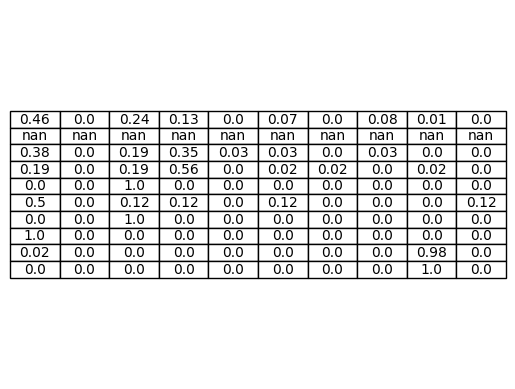

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Display the matrix
fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=transition_matrix.round(2), loc='center', cellLoc='center')

plt.show()


In [23]:
print(pd.DataFrame(data=transition_matrix, index=states, columns=states))

           P    D        IP        ID        VP         R        IR        VR  \
P   0.464789  0.0  0.239437  0.126761  0.000000  0.070423  0.000000  0.084507   
D        NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
IP  0.378378  0.0  0.189189  0.351351  0.027027  0.027027  0.000000  0.027027   
ID  0.192308  0.0  0.192308  0.557692  0.000000  0.019231  0.019231  0.000000   
VP  0.000000  0.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
R   0.500000  0.0  0.125000  0.125000  0.000000  0.125000  0.000000  0.000000   
IR  0.000000  0.0  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VR  1.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
M   0.016393  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
d   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           M      d  
P   0.014085  0.000  
D        NaN    NaN  
IP  0.000000  0.000  
ID  0.019231  0.000 

In [24]:
def print_markov_chain(matrix):
    print("Markov Chain Transition Matrix:")
    print("   ", end='')
    for i in range(len(matrix)):
        print(f"  S{i}", end='')
    print()
    for index, row in enumerate(matrix):
        print(f"S{index} [", end='')
        for elem in row:
            print(f"{elem:.2f} ", end='')
        print("]")

# Print the matrix
print_markov_chain(transition_matrix)

Markov Chain Transition Matrix:
     S0  S1  S2  S3  S4  S5  S6  S7  S8  S9
S0 [0.46 0.00 0.24 0.13 0.00 0.07 0.00 0.08 0.01 0.00 ]
S1 [nan nan nan nan nan nan nan nan nan nan ]
S2 [0.38 0.00 0.19 0.35 0.03 0.03 0.00 0.03 0.00 0.00 ]
S3 [0.19 0.00 0.19 0.56 0.00 0.02 0.02 0.00 0.02 0.00 ]
S4 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
S5 [0.50 0.00 0.12 0.12 0.00 0.12 0.00 0.00 0.00 0.12 ]
S6 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
S7 [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
S8 [0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.98 0.00 ]
S9 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 ]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (30, 2) + inhomogeneous part.

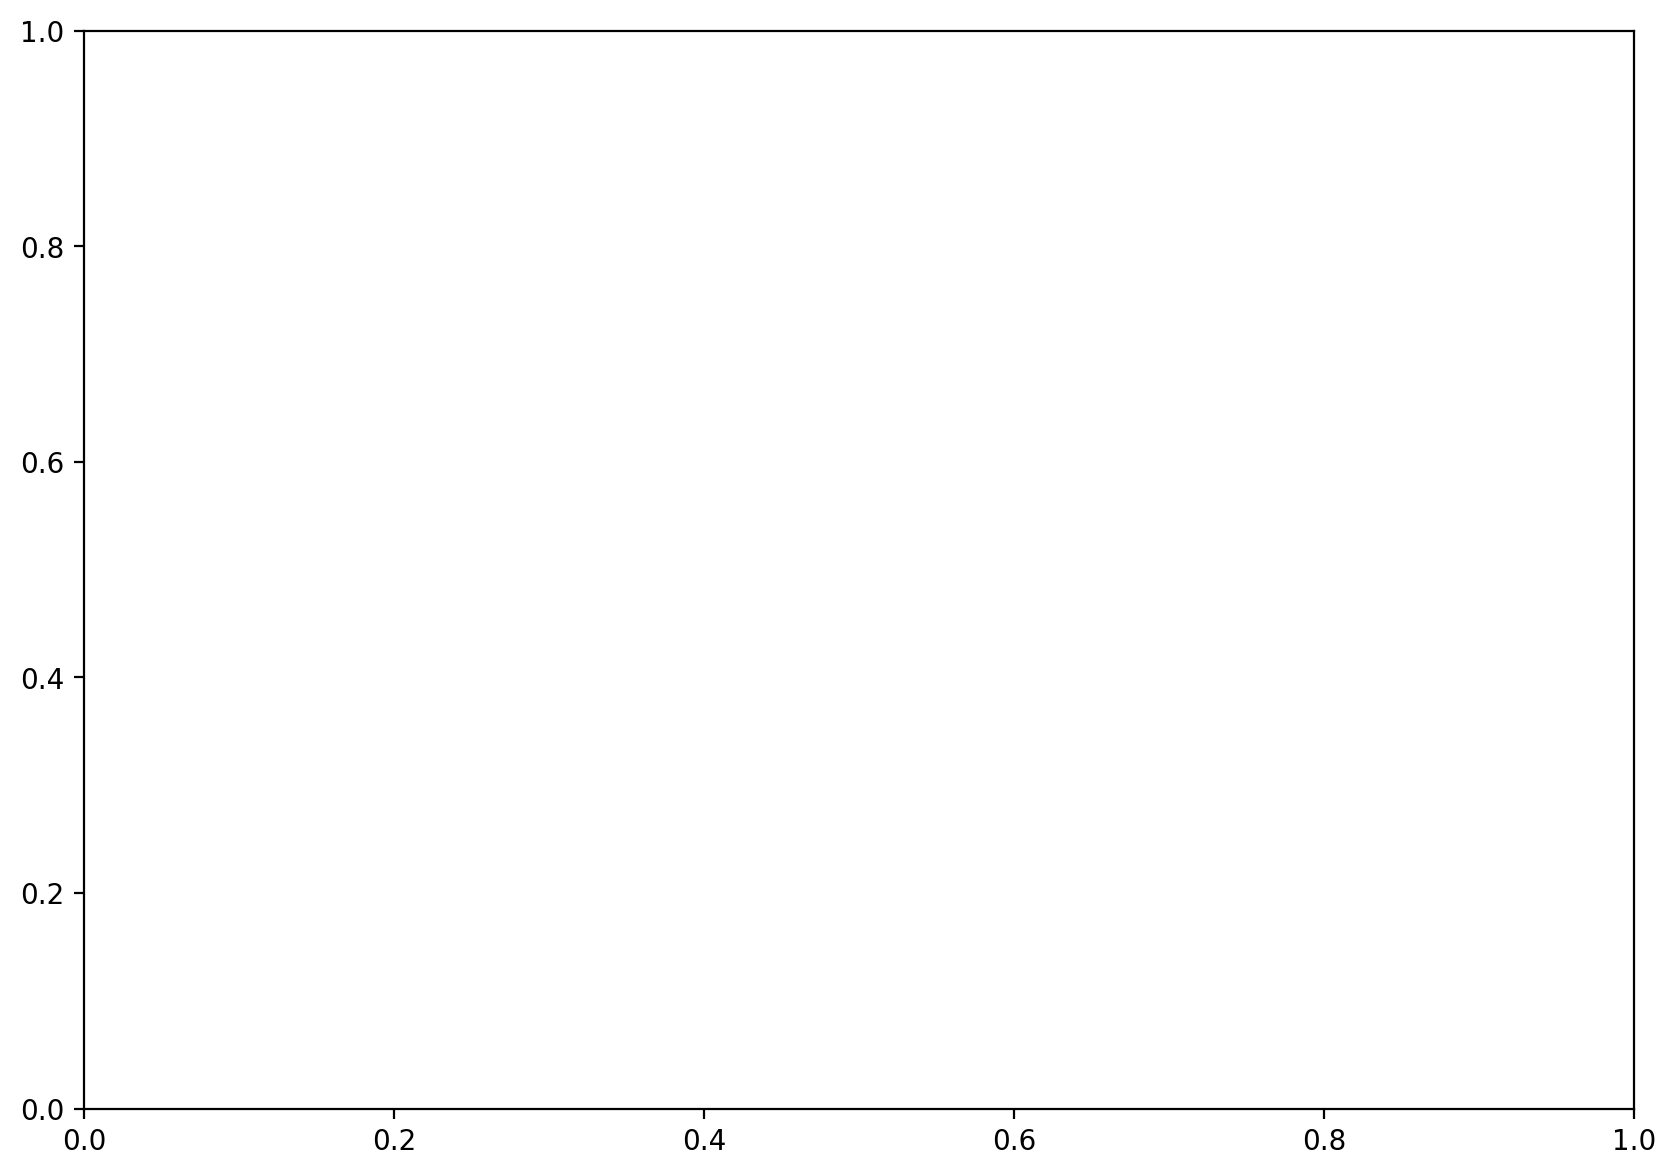

In [45]:
# temporarily hardcoded
states = ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']

# temporarily hardcoded
Q = [[0.46478873, 0, 0.23943662, 0.12676056, 0, 0.07042254, 0, 0.08450704, 0.01408451, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0.37837838, 0, 0.18918919, 0.35135135, 0.02702703, 0.02702703, 0, 0.02702703, 0, 0],
     [0.19230769, 0, 0.19230769, 0.55769231, 0, 0.01923077, 0.01923077, 0, 0.01923077, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0.5, 0, 0.125, 0.125, 0, 0.125, 0, 0, 0, 0.125],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0.01639344, 0, 0, 0, 0, 0, 0, 0, 0.98360656, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]


G = nx.MultiDiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        rate = Q[i][j]
        if rate > 0:
            G.add_edge(origin_state, destination_state, weight=rate, label="{:.02f}".format(rate))
            edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)



plt.figure(figsize=(10,7))
node_size = 200
pos = {state:list(state) for state in states}
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off')
plt.show()

write_dot(G, 'mc.dot')

from subprocess import check_call
nfile = 'w.png' 
check_call(['dot', '-Tpng', 'mc.dot', '-o', nfile])

import matplotlib.image as mpimg
img = mpimg.imread(nfile)
plt.axis('off')
plt.imshow(img)
plt.show()

# IGNORE AFTER THIS PART

In [25]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
def print_markov_chain(matrix):
    print("Markov Chain Transition Matrix:")
    print("   ", end='')
    for i in range(len(matrix)):
        print(f"  S{i}", end='')
    print()
    for index, row in enumerate(matrix):
        print(f"S{index} [", end='')
        for elem in row:
            print(f"{elem:.2f} ", end='')
        print("]")

# Print the matrix
print_markov_chain(transition_matrix)

Markov Chain Transition Matrix:
     S0  S1  S2  S3  S4  S5  S6  S7  S8  S9
S0 [0.46 0.00 0.24 0.13 0.00 0.07 0.00 0.08 0.01 0.00 ]
S1 [nan nan nan nan nan nan nan nan nan nan ]
S2 [0.38 0.00 0.19 0.35 0.03 0.03 0.00 0.03 0.00 0.00 ]
S3 [0.19 0.00 0.19 0.56 0.00 0.02 0.02 0.00 0.02 0.00 ]
S4 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
S5 [0.50 0.00 0.12 0.12 0.00 0.12 0.00 0.00 0.00 0.12 ]
S6 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
S7 [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 ]
S8 [0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.98 0.00 ]
S9 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 ]


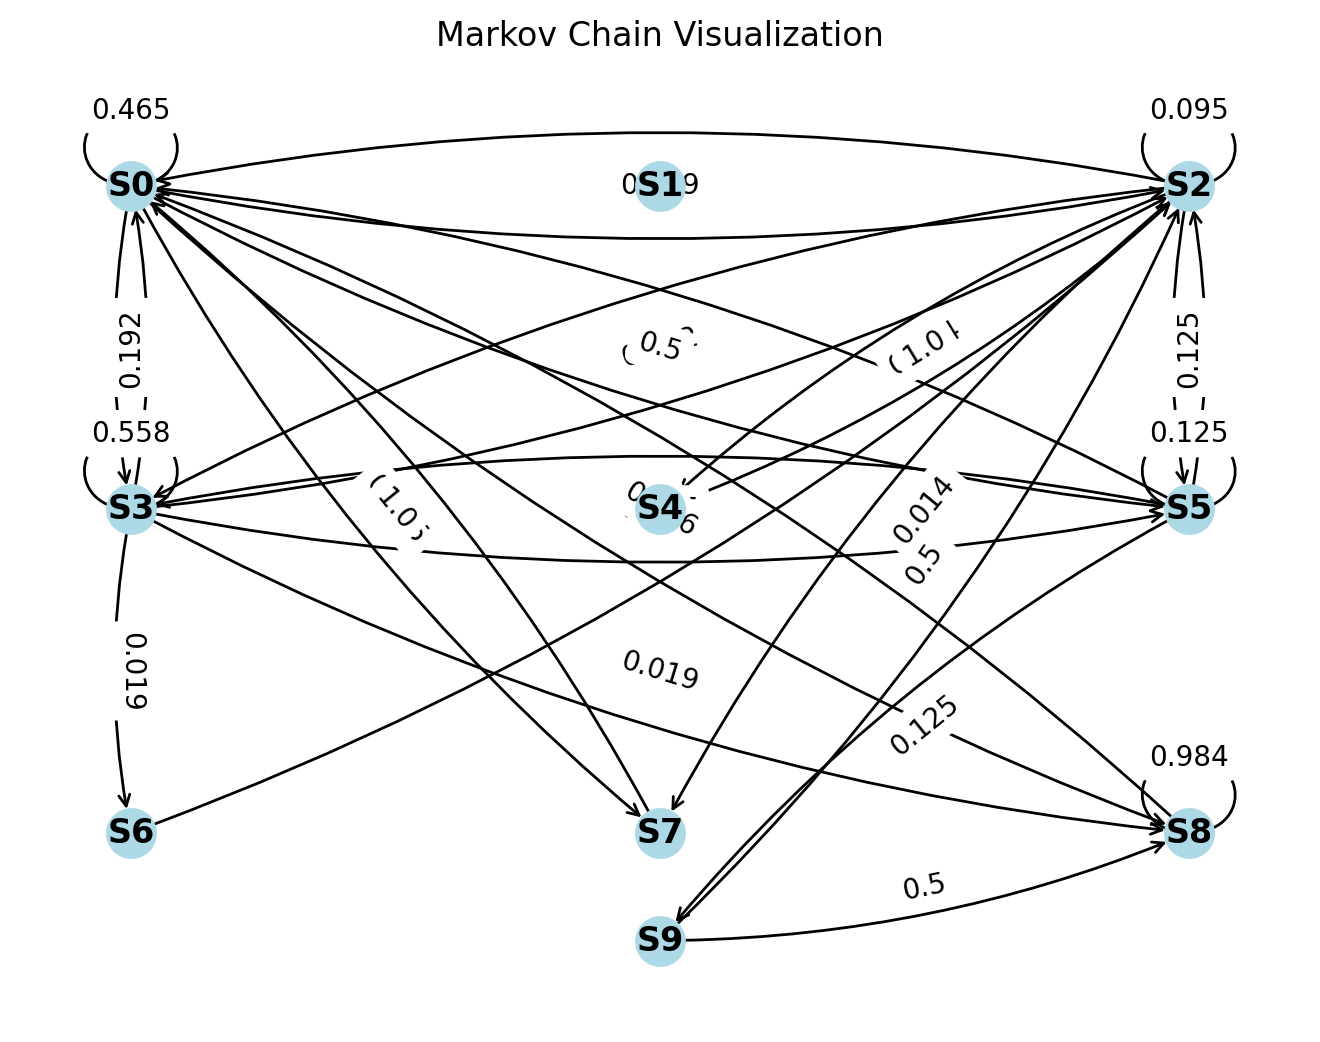

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the states as node labels
states = ["S0", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9"]

# Create an empty directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(states)

# Add edges with weights based on transition probabilities
for i, row in enumerate(transition_matrix):  # Assuming 'transition_matrix' holds your data
    for j, prob in enumerate(row):
        if prob > 0:  # Only add edges with non-zero probability
            G.add_edge(states[i], states[j], weight=prob)

# Set node positions (optional, adjust for better visualization)
pos = {
    "S0": (0.2, 0.8), "S1": (0.5, 0.8), "S2": (0.8, 0.8), "S3": (0.2, 0.5),
    "S4": (0.5, 0.5), "S5": (0.8, 0.5), "S6": (0.2, 0.2), "S7": (0.5, 0.2),
    "S8": (0.8, 0.2), "S9": (0.5, 0.1)
}

# Extract weights (probabilities) for edge labels
edge_labels = dict(nx.get_edge_attributes(G, 'weight'))

# Draw the graph with labels and weights
# nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', edge_color='black', font_size=12, arrows=True, arrowstyle='->', arrowsize=10, connectionstyle='ee')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='black')
# Draw the graph with labels and weights
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', edge_color='black', font_size=12, arrows=True, arrowstyle='->', arrowsize=10, connectionstyle='arc3,rad=0.1')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='black')

# Customize plot (optional)
plt.title("Markov Chain Visualization")
plt.axis('off')
plt.show()


# # Customize plot (optional)
# plt.title("Markov Chain Visualization")
# plt.axis('off')
# plt.show()

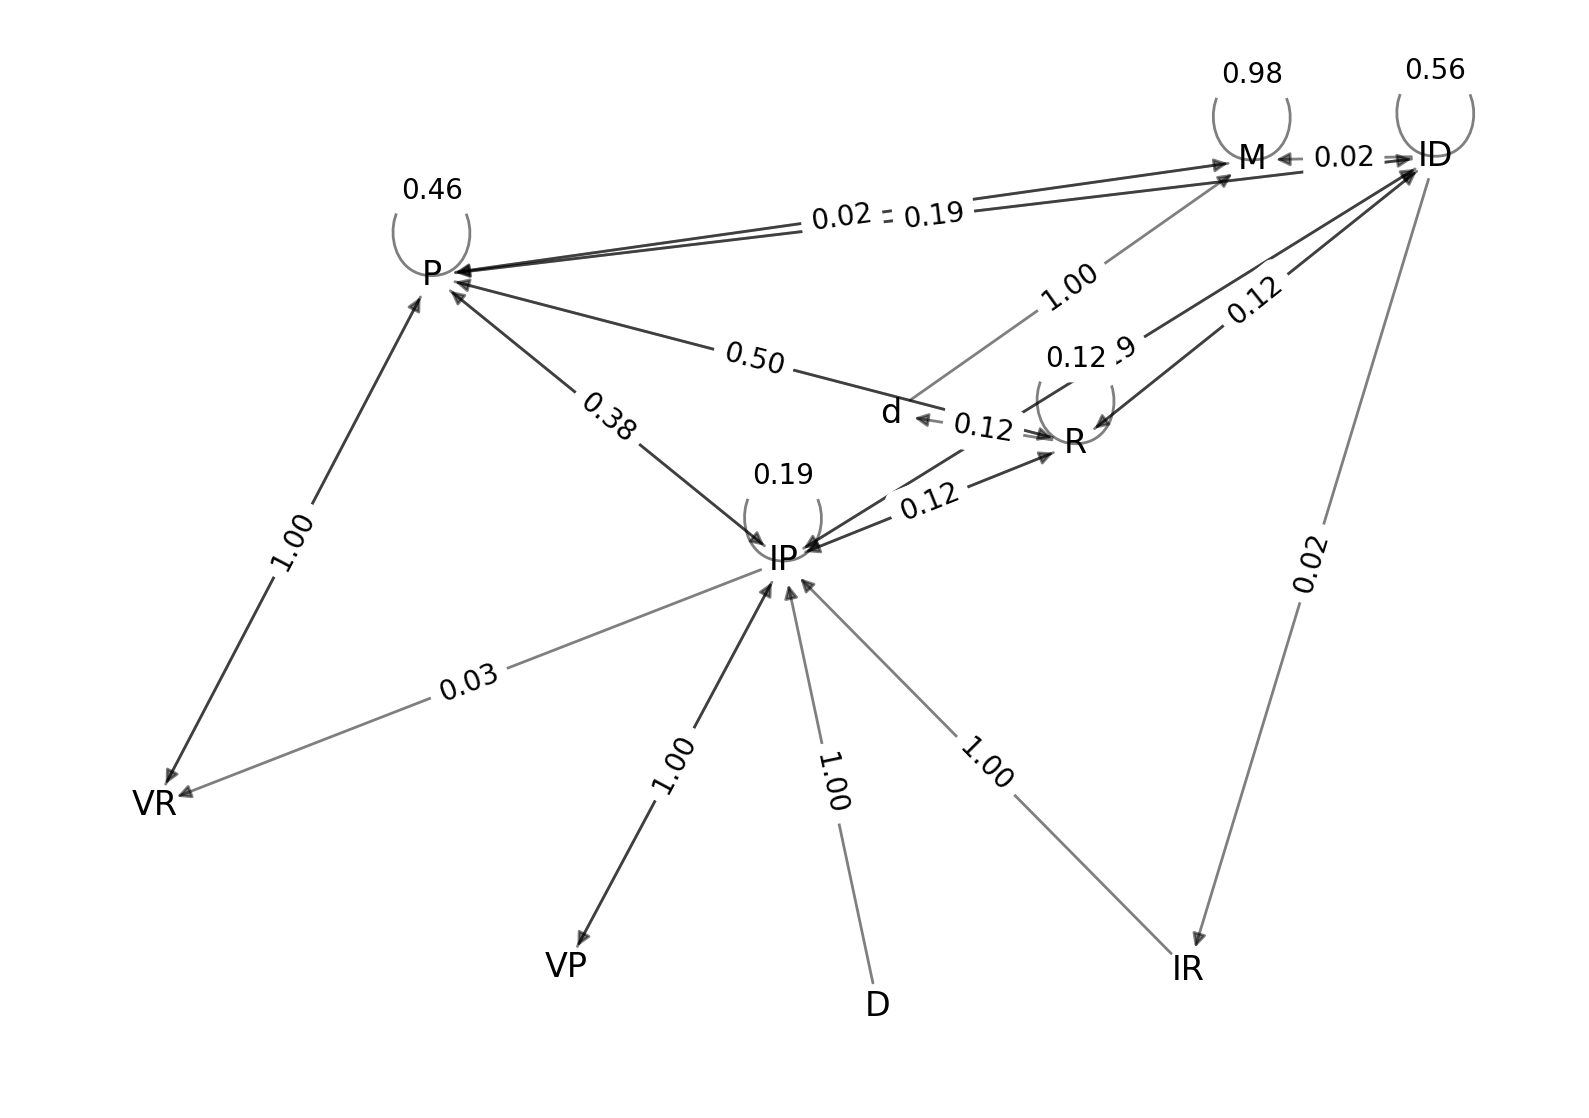

ModuleNotFoundError: No module named 'pydot'

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import write_dot
from subprocess import check_call
import matplotlib.image as mpimg

states = ['P', 'D', 'IP', 'ID', 'VP', 'R', 'IR', 'VR', 'M', 'd']
Q = [
     [0.46478873, 0, 0.23943662, 0.12676056, 0, 0.07042254, 0, 0.08450704, 0.01408451, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0.37837838, 0, 0.18918919, 0.35135135, 0.02702703, 0.02702703, 0, 0.02702703, 0, 0],
     [0.19230769, 0, 0.19230769, 0.55769231, 0, 0.01923077, 0.01923077, 0, 0.01923077, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0.5, 0, 0.125, 0.125, 0, 0.125, 0, 0, 0, 0.125],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0.01639344, 0, 0, 0, 0, 0, 0, 0, 0.98360656, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
]

G = nx.MultiDiGraph()
edge_labels = {}

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        rate = Q[i][j]
        if rate > 0:
            G.add_edge(origin_state, destination_state, weight=rate, label="{:.02f}".format(rate))
            edge_labels[(origin_state, destination_state)] = "{:.02f}".format(rate)

pos = nx.spring_layout(G)  # Generates a spring layout

plt.figure(figsize=(10, 7))
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off')
plt.show()

write_dot(G, 'mc.dot')

nfile = 'w.png' 
check_call(['dot', '-Tpng', 'mc.dot', '-o', nfile])

img = mpimg.imread(nfile)
plt.axis('off')
plt.imshow(img)
plt.show()


In [ ]:
score = converter.parse(midi)

In [ ]:
score.parts

<music21.stream.iterator.StreamIterator for Score:0x2833b2aac10 @:0>

In [ ]:
detect_closures(score)

[]

In [ ]:
assign_ir_symbols(score)

AttributeError: 'Part' object has no attribute 'pitch'

In [ ]:
from music21 import converter

# Load the score
score = converter.parse(midi)  # Replace with your file path

# Iterate over all parts in the score
for part in score.parts:
    print(f"Inspecting part: {part.id}")
    # Iterate over all measures in each part
    for measure in part.getElementsByClass('Measure'):
        print(f"Measure {measure.number}:")
        # Iterate over all notes in the measure
        for note in measure.notes:
            # Here we print some attributes of each note
            print(f"Note: {note.nameWithOctave}, Duration: {note.duration.quarterLength}, Offset: {note.offset}")
            if note.lyrics:
                # Print lyrics if the note has any
                print(f"    Lyrics: {' '.join(lyric.text for lyric in note.lyrics)}")


In [ ]:
from music21 import converter, note, chord, stream


In [ ]:
from music21 import environment
# Set the path to MuseScore
env = environment.Environment()
env['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
env['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'


0 2195067343888
1 2194999715472
2 2195066344592


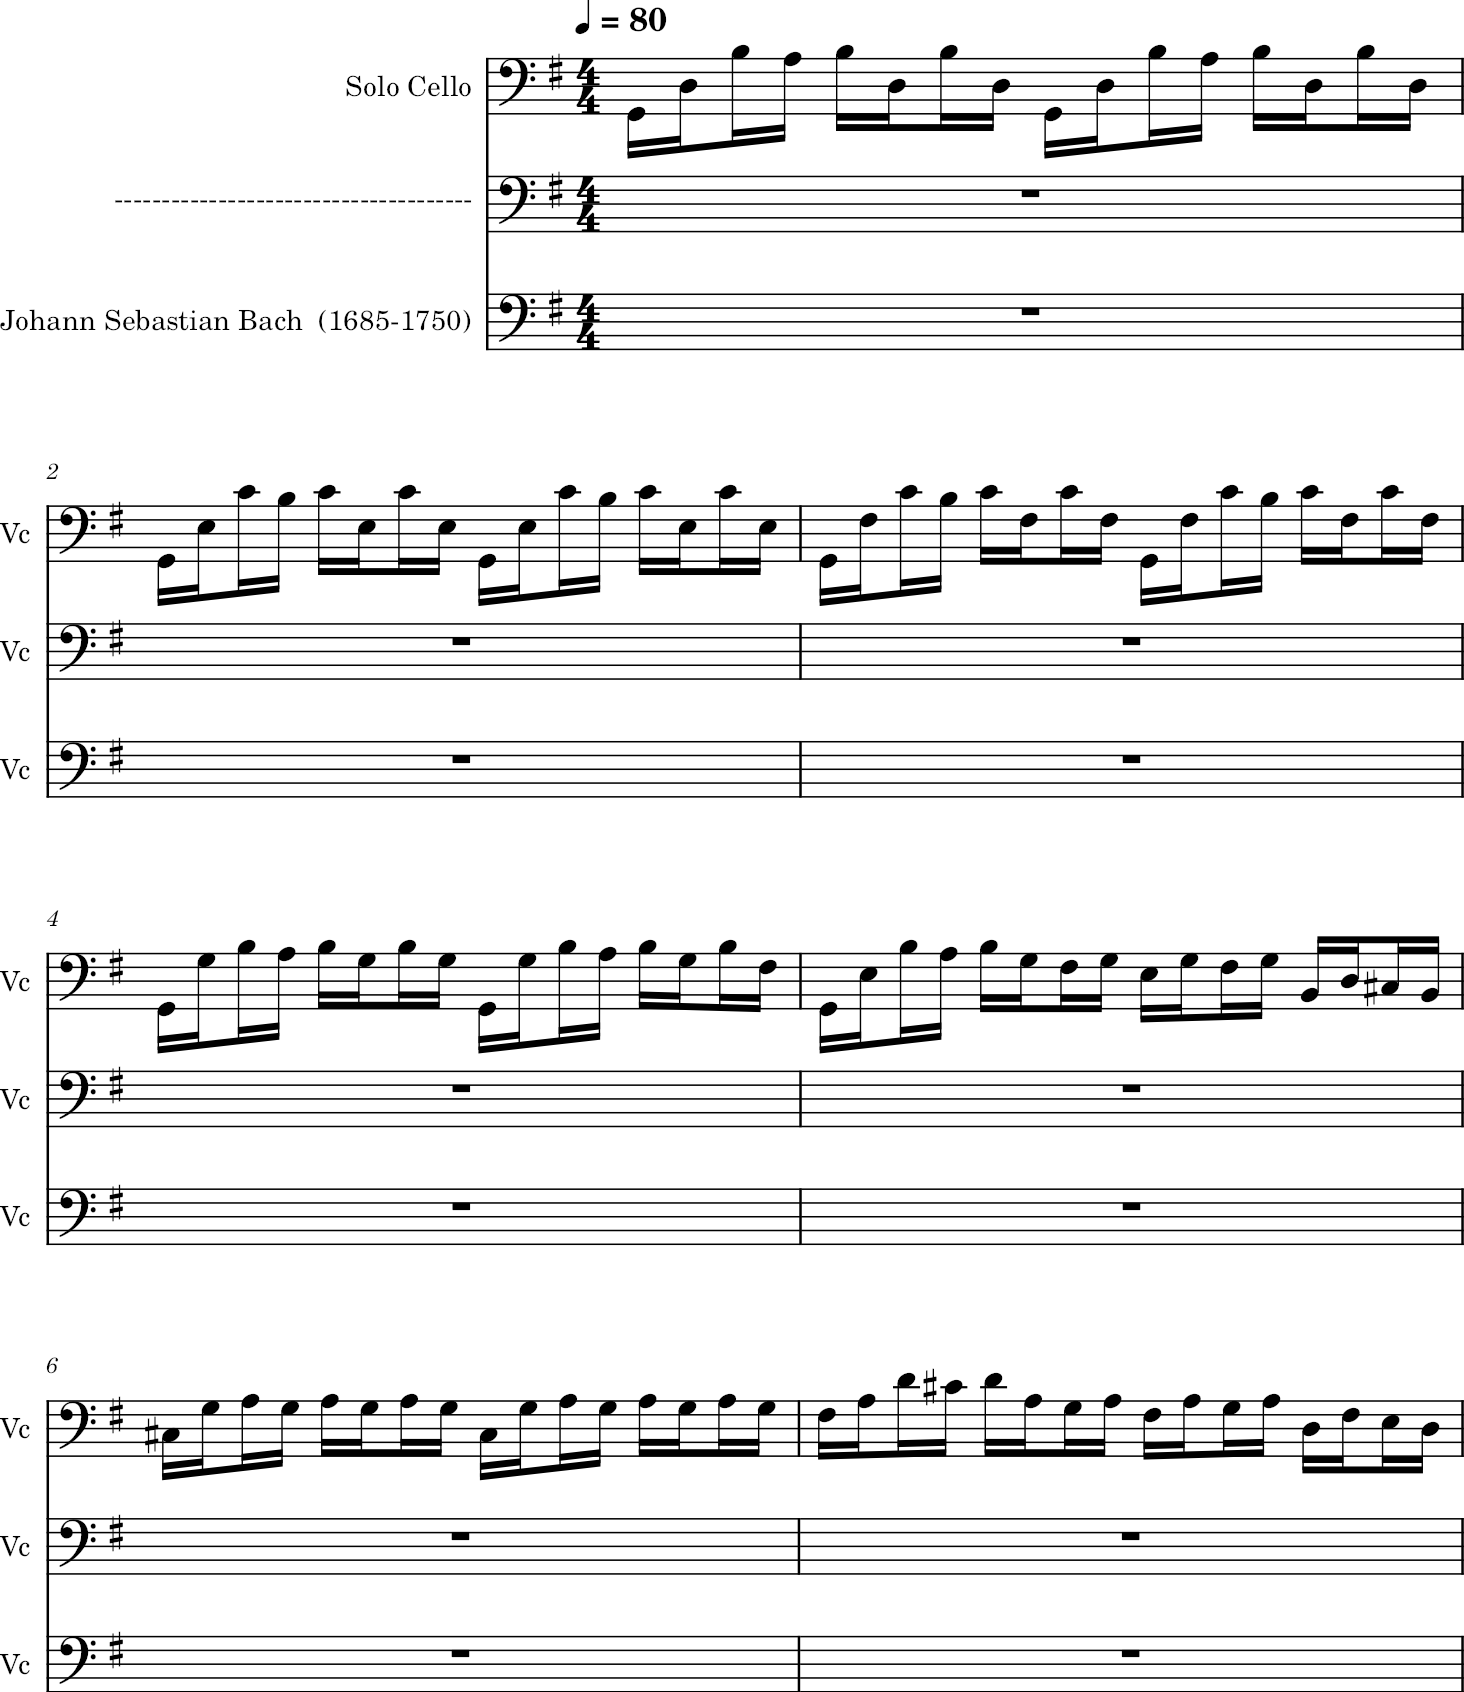

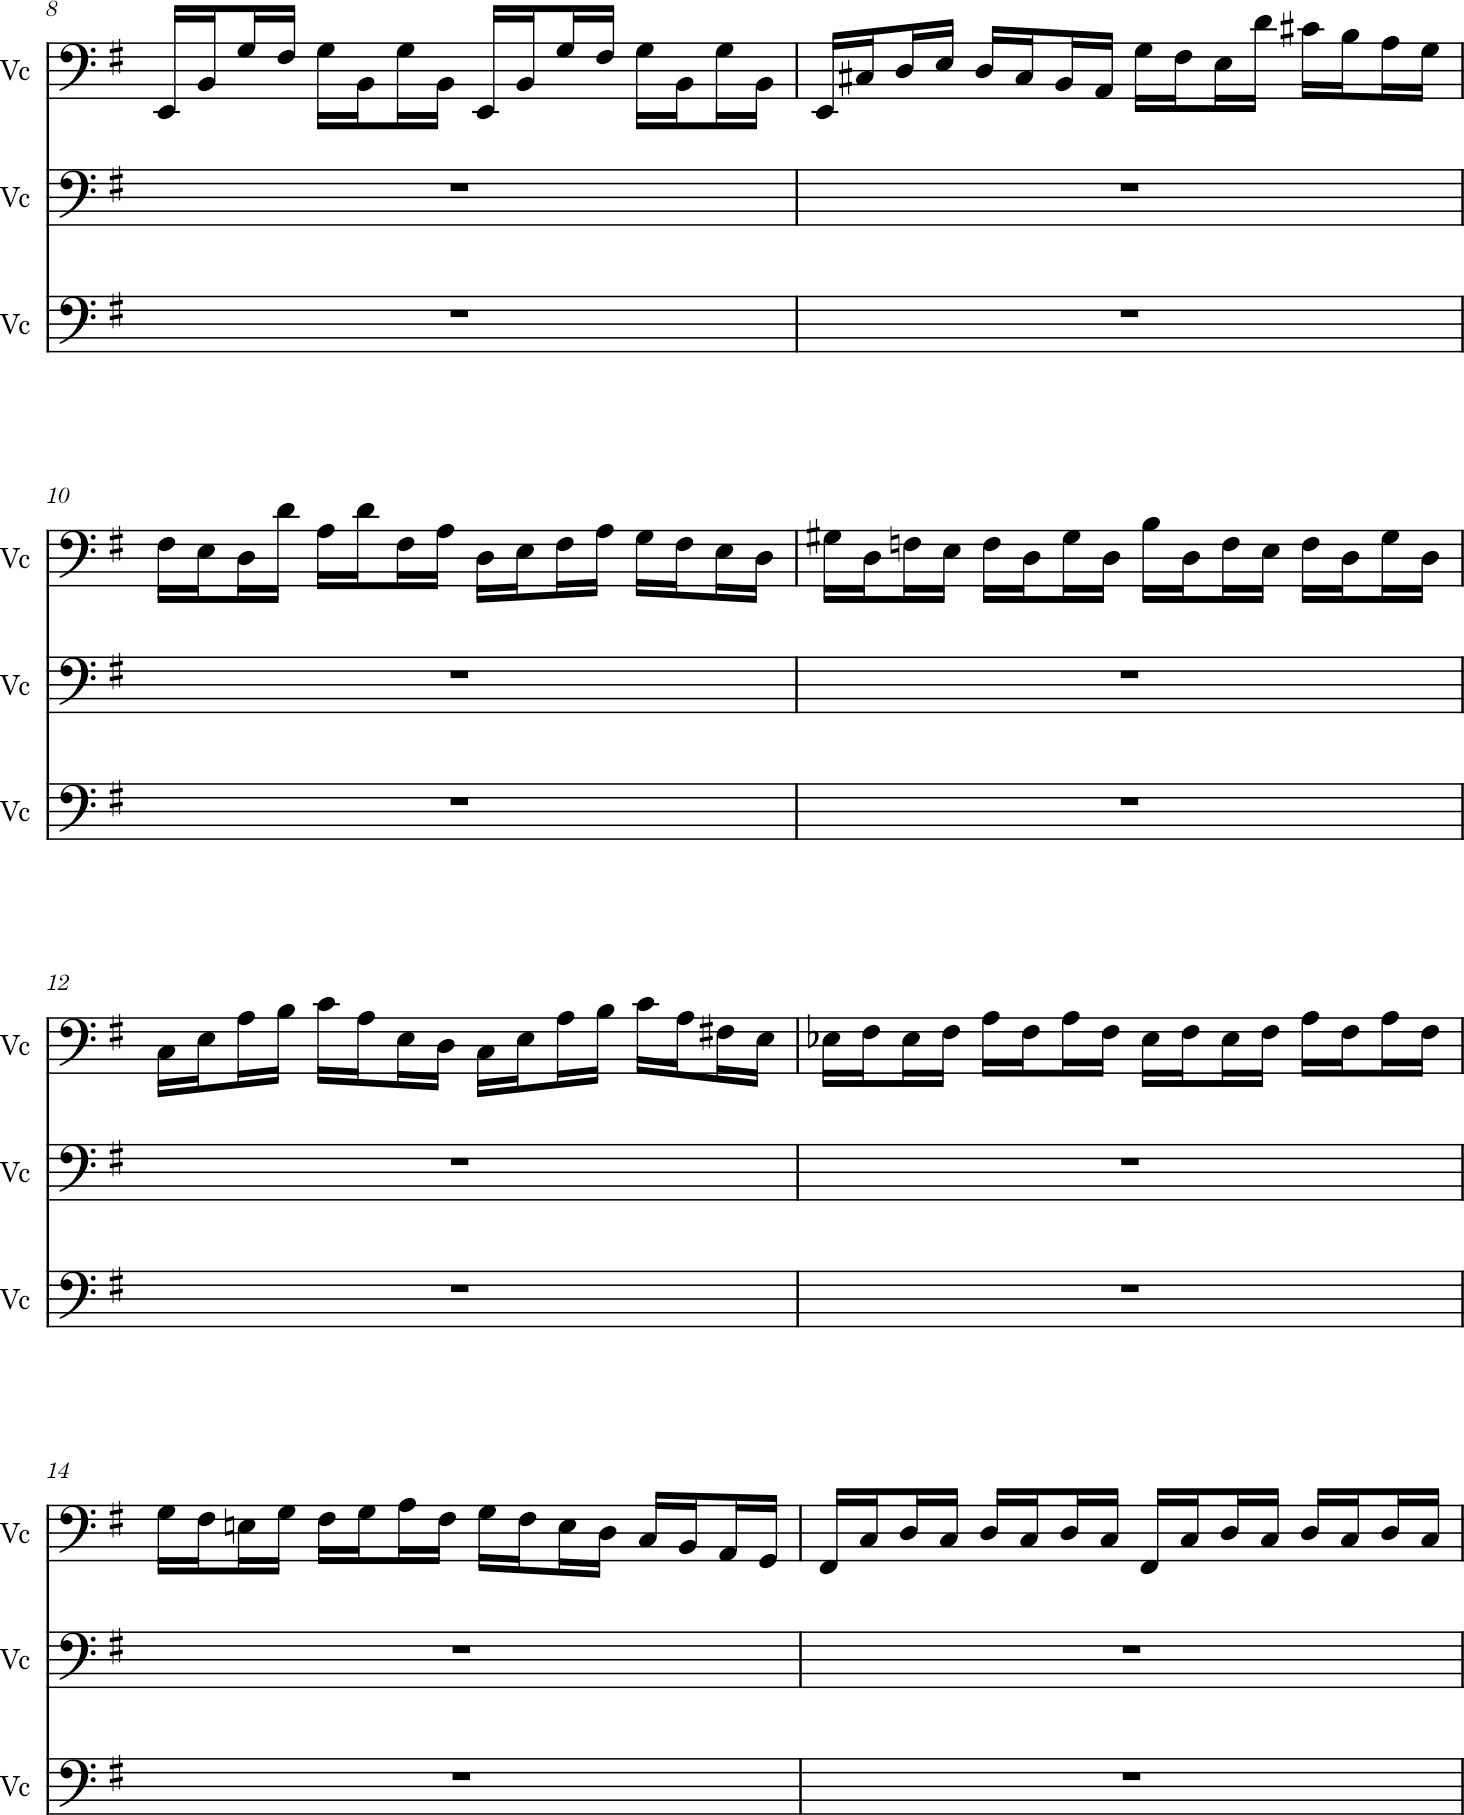

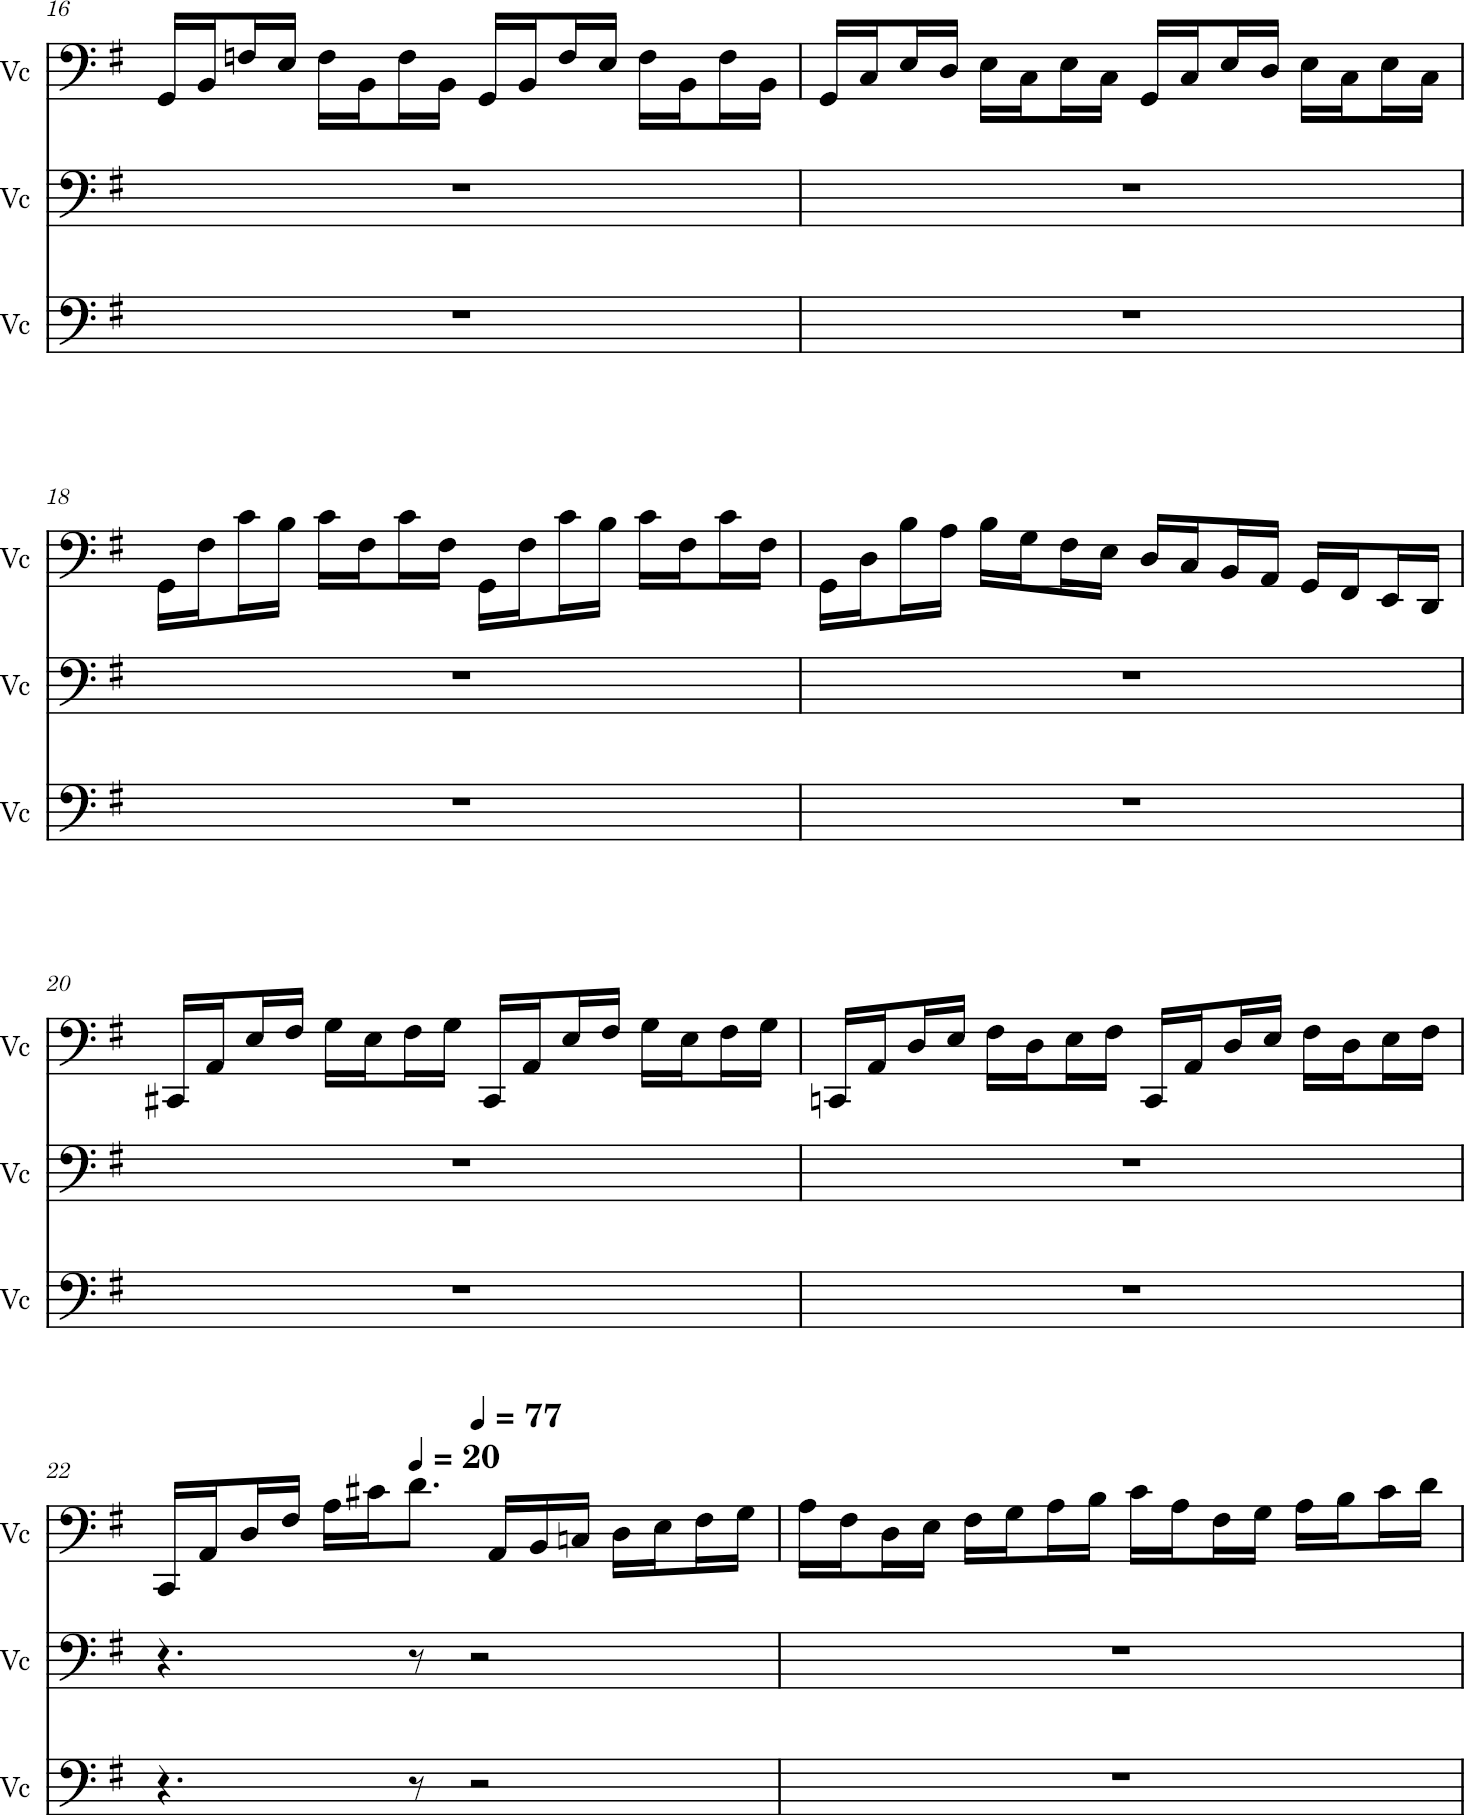

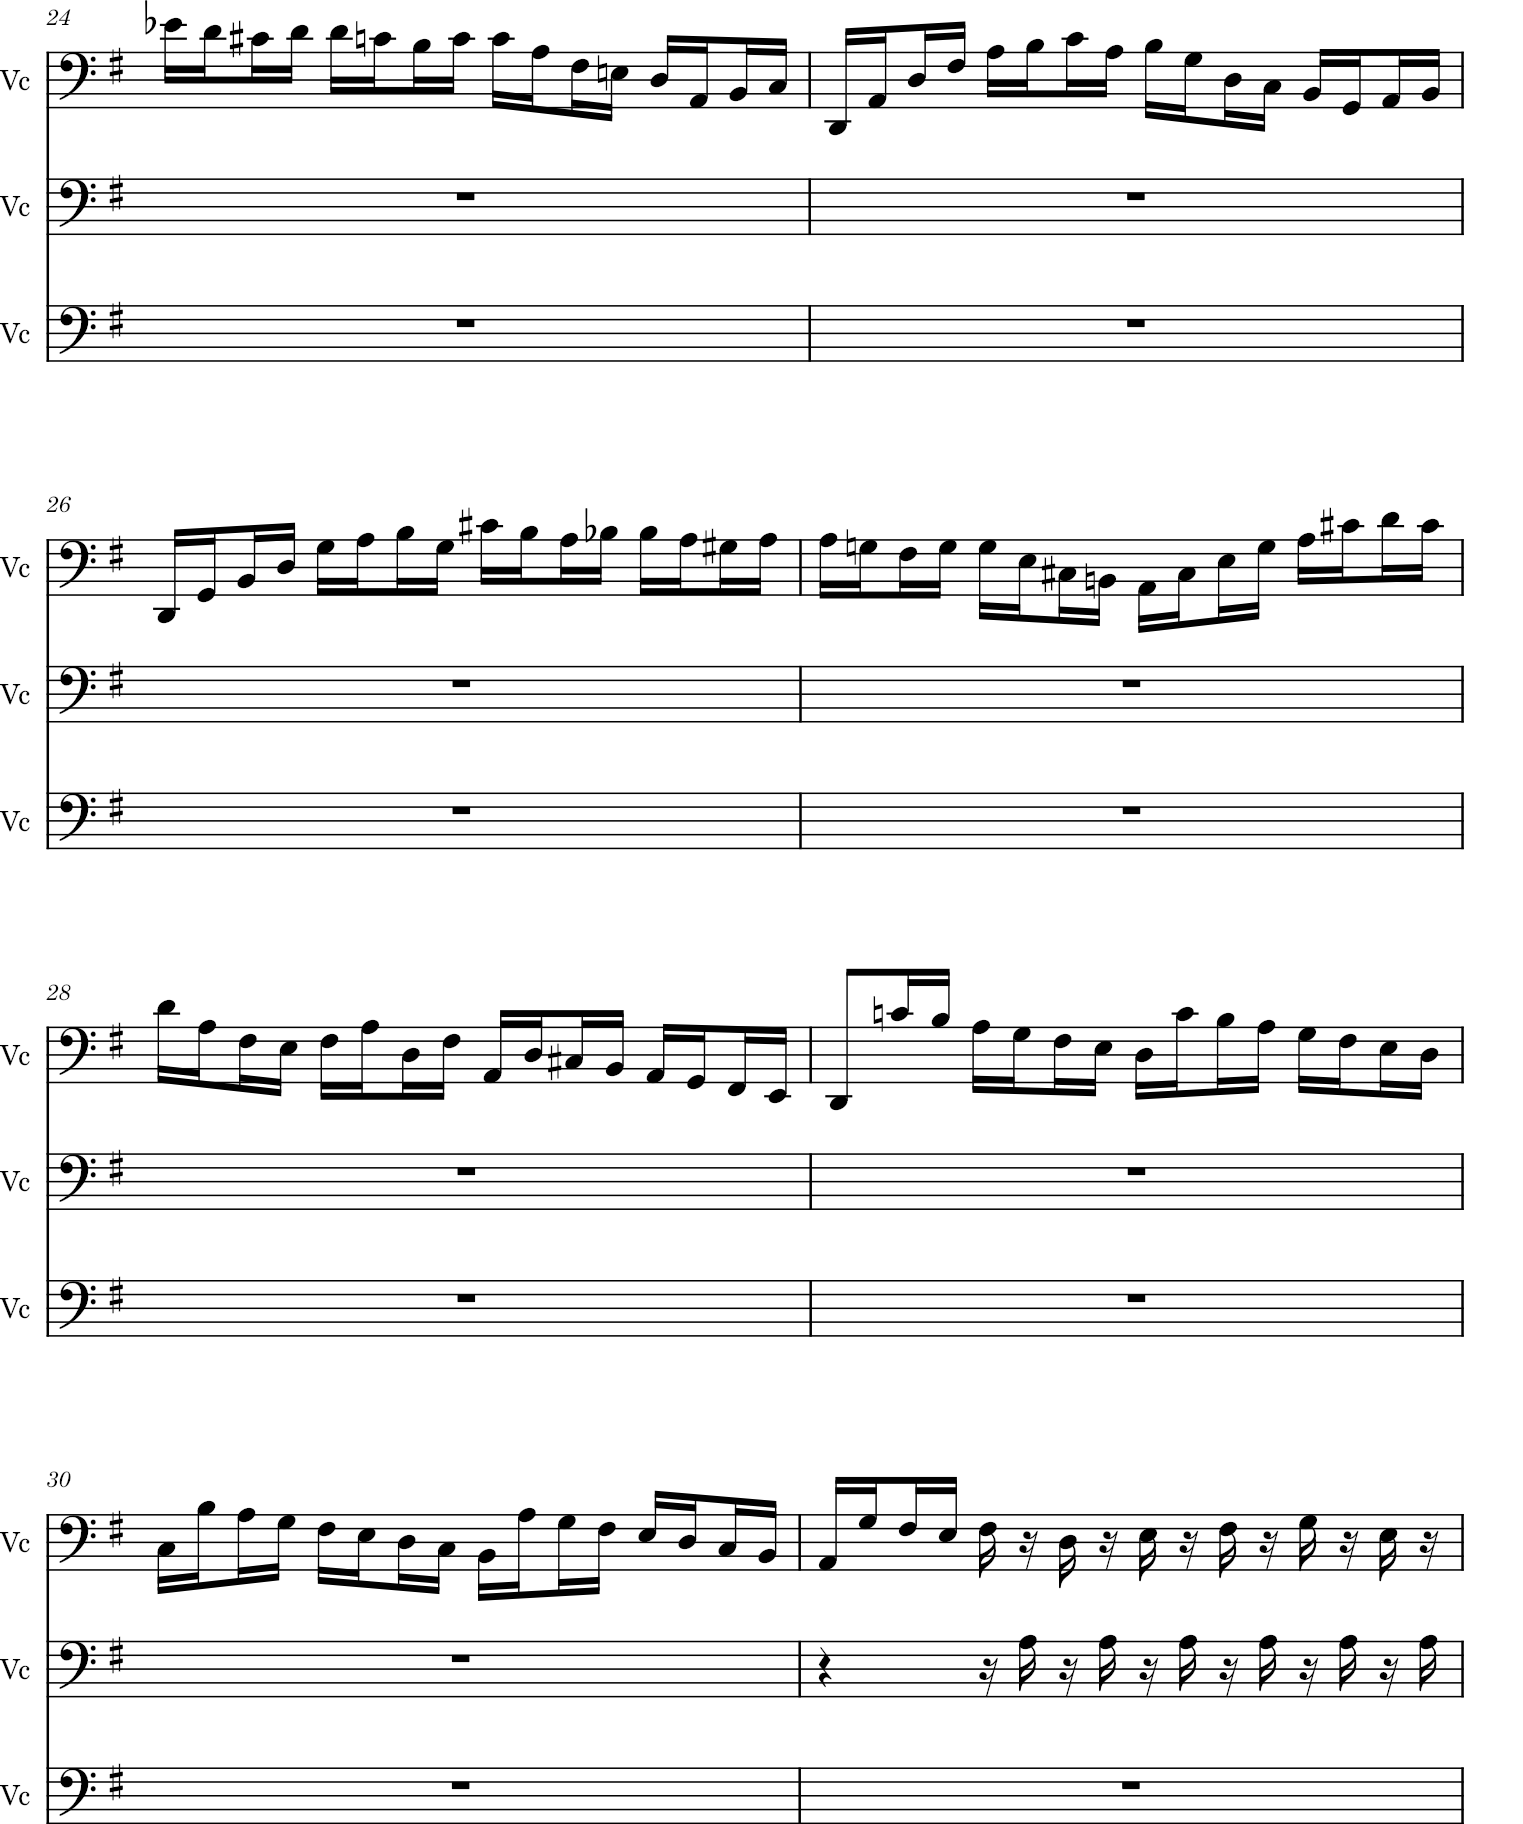

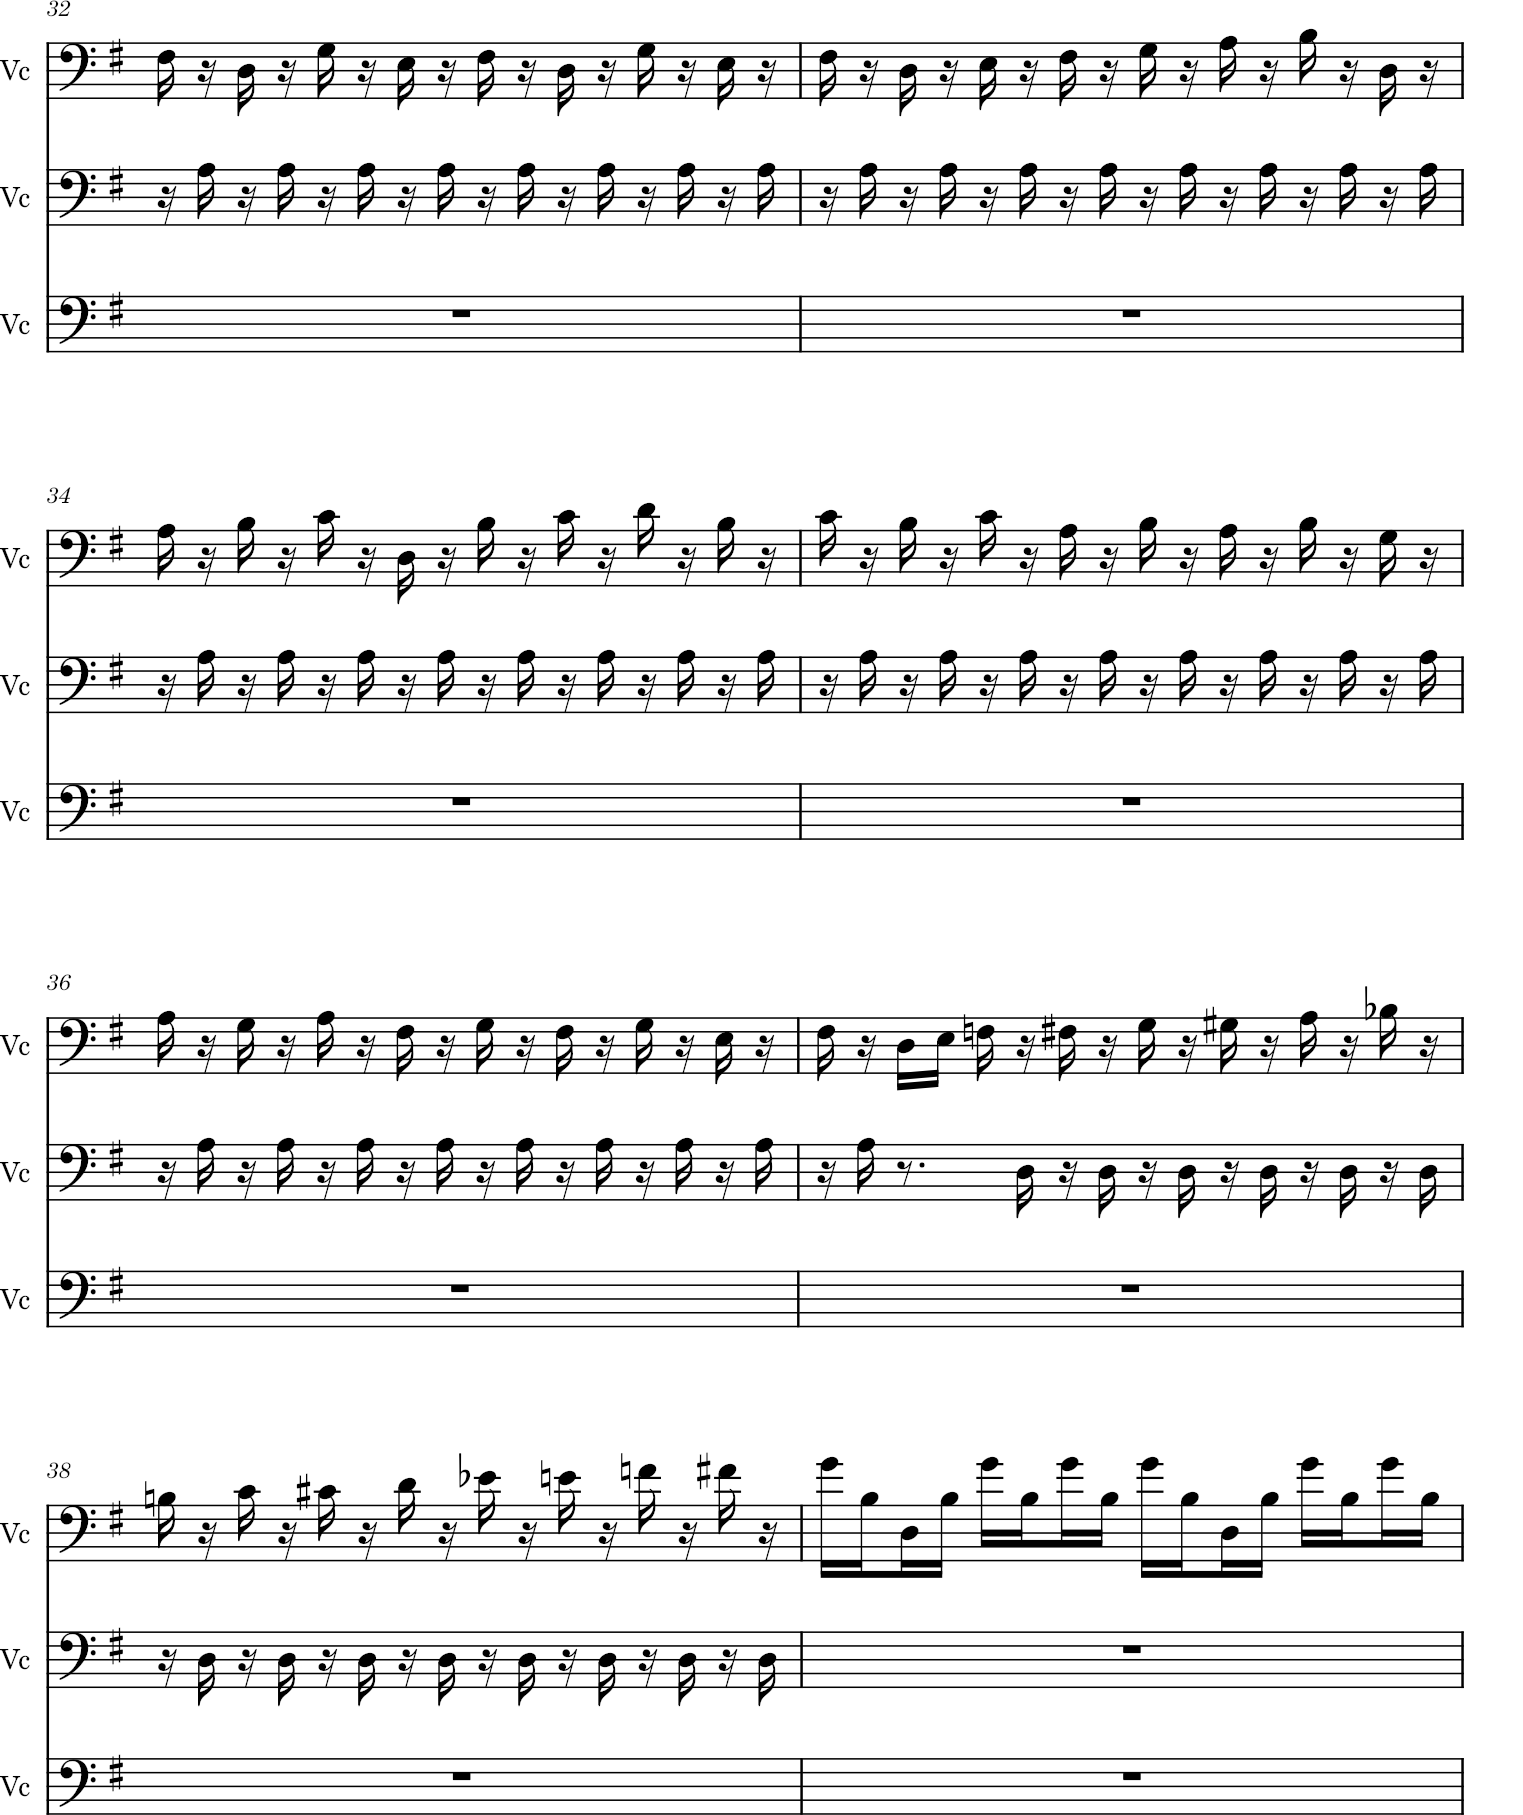

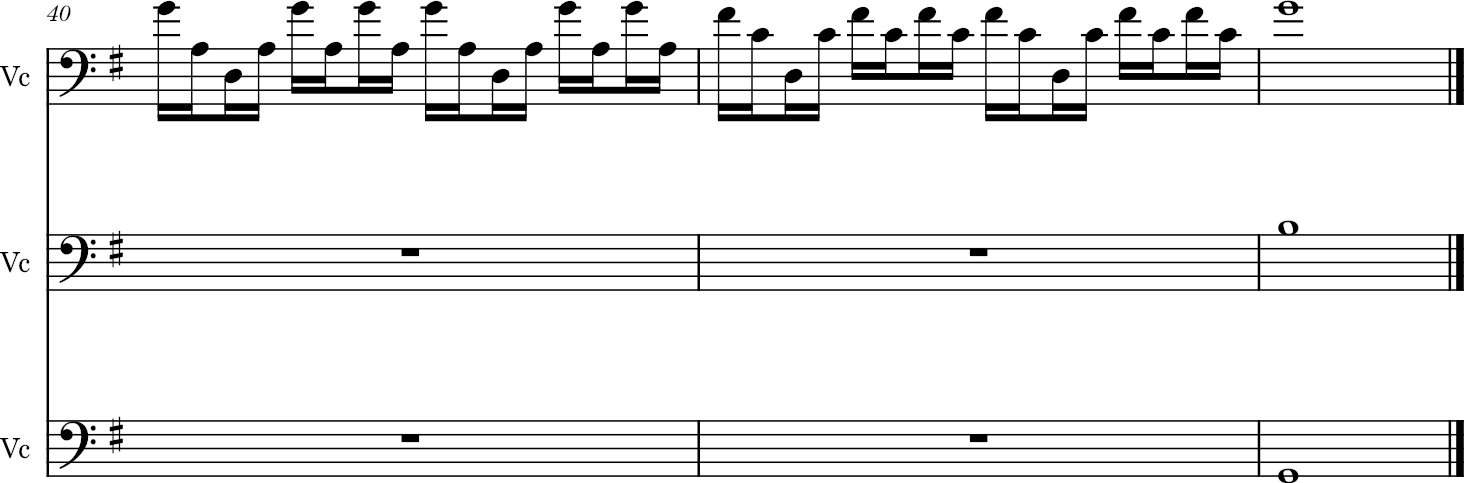

In [ ]:
# Load the MIDI file
score = converter.parse('bach/cs1-1pre.mid')
for idx, part in enumerate(score.parts):
    print(idx, part.id)
part = score.parts[0]
score.show()

In [ ]:
def calculate_iois(score):
    iois = []
    previous_offset = None

    # Use .flatten() instead of .flat
    for elem in score.flatten().notesAndRests:
        if previous_offset is not None:
            ioi = elem.offset - previous_offset
            iois.append(ioi)
        previous_offset = elem.offset
    
    return iois


In [ ]:
def detect_closures(iois, threshold=1.5):
    closures = []
    for i in range(1, len(iois)):
        #if abs(iois[i] > iois[i-1]) > 2:
        if iois[i] > iois[i-1] * threshold:
            closures.append(i)  # Index of the note after the long IOI
    return closures


In [ ]:
def highlight_closures(score, closures):
    highlighted = stream.Score()
    index = 0
    for elem in score.flatten().notesAndRests:
        new_element = elem
        if isinstance(elem, note.Note):
            new_element = note.Note(elem.pitch, quarterLength=elem.duration.quarterLength)
        elif isinstance(elem, chord.Chord):
            new_element = chord.Chord(elem.pitches, quarterLength=elem.duration.quarterLength)
        
        if index in closures:
            new_element.style.color = 'red'  # Highlight in red
        highlighted.append(new_element)
        index += 1
    return highlighted


In [ ]:
iois = calculate_iois(part)
iois

In [ ]:
closures = detect_closures(iois)
highlighted_score = highlight_closures(part, closures)
highlighted_score.show()


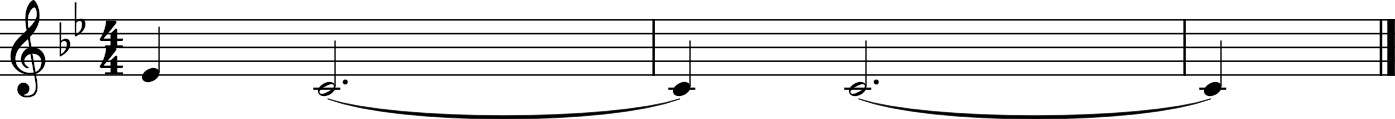

In [ ]:

# Create a stream for the piece
s = stream.Stream()

# Set the time signature
s.timeSignature = meter.TimeSignature('4/4')

# Set the key signature
s.keySignature = key.KeySignature(-2) # Bb major

# Add a whole note 'C4'
n1 = note.Note('C4', duration=duration.Duration(type='whole'))
n3 = note.Note('C4', duration=duration.Duration(type='whole'))

# Add a quarter note 'E-4'
n2 = note.Note('E-4', duration=duration.Duration(type='quarter'))
n4 = note.Note('E-4', duration=duration.Duration(type='quarter'))
rest = note.Rest

# Add triplet eighth notes 'F4', 'G4', 'A4'
# tuplet_notes = ['F4', 'G4', 'A4']
# for pitch in tuplet_notes:
#     n = note.Note(pitch, duration=duration.Duration(type='eighth'))
#     tup = duration.Tuplet(numberNotesActual=3, numberNotesNormal=2)
#     n.duration.appendTuplet(tup)
#     s.append(n)

# Add the notes to the stream
s.append(n4)
s.append(n1)
s.append(n3)


# Show the music
s.show()


In [ ]:
iois = calculate_iois(s)
iois

[1.0, 4.0]

In [ ]:
closures = detect_closures(iois)
closures

[1]

C:\Users\oyutn\AppData\Roaming\Python\Python311\site-packages\music21\musicxml\m21ToXml.py:531: MusicXMLWarning: <music21.stream.Score 0x2833ec4d4d0> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{sc} is not well-formed; see isWellFormedNotation()',


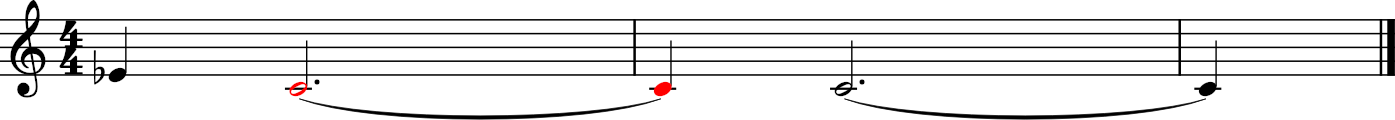

In [ ]:
highlighted_score = highlight_closures(s, closures)
highlighted_score.show()